In [111]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

# Описание задания
А/А-тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана.

# Загрузим данные

## Описание колонок
* **experimentVariant** – вариант эксперимента
* **version** – версия приложения
* **purchase** – факт покупки

In [112]:
df = pd.read_csv('hw_aa.csv', sep = ';', index_col=0)

## Посмотрим на данные и типы данных

In [113]:
print(f'''
количество строк: {df.shape[0]}
количество колонок: {df.shape[1]}
количество пропущенных значений: {df.isna().sum().sum()}
''')


количество строк: 127018
количество колонок: 4
количество пропущенных значений: 0



In [114]:
for c in df.columns:
    dtype = df[c].dtype
    nunique = df[c].nunique()
    unique = '[...]'
    if nunique <= 5:
       unique =  df[c].unique()
    print(f'{c}({dtype}) : {nunique} : {unique}')

uid(object) : 127018 : [...]
experimentVariant(int64) : 2 : [1 0]
version(object) : 4 : ['v2.8.0' 'v2.9.0' 'v3.7.4.0' 'v3.8.0.0']
purchase(int64) : 2 : [0 1]


# Задача 1
Запустите A/A-тест


In [191]:
# определим функцию для запуска A/A теста, визуализации полученных p-value
def get_aa_pvalues(a1: pd.Series, a2: pd.Series, simulations: int, n_s: int, hist_title: str = '', display_hist: bool = True):
    res = []
    # Запуск симуляций A/A теста
    for i in tqdm(range(simulations)):
        s1 = a1.sample(n_s, replace = False).values
        s2 = a2.sample(n_s, replace = False).values
        res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

    if display_hist:
        # визуализация
        plt.hist(res, bins = 50)
        plt.style.use('ggplot')
        plt.xlabel('pvalues')
        plt.ylabel('frequency')
        plt.title(f'Histogram of ttest A/A simulations {hist_title}')
        plt.show()

    return res

In [246]:
# обределим функцию для проверки величины FPR для заданных альфа уровней
def print_conglusion_by_fpr(fpr: dict):
    for alpha in fpr:
        if fpr[alpha] > alpha:
            print(f'частота ложноположительных случаев {fpr[alpha]} превышает альфа {alpha}')
        else:
            print(f'частота ложноположительных случаев {fpr[alpha]} НЕ превышает альфа {alpha}')

In [196]:
# обределим функцию для проверки ложноположительных случаев
def get_fpr_by_alpha(pvalues, alpha_levels):
    alphas = {}

    l = len(pvalues)
    np_arr = np.array(pvalues)

    # Проверяем, что количество ложноположительных случаев не превышает альфа
    for a in alpha_levels:
        alphas[a] = sum(np_arr < a) / l
    
    return alphas

In [180]:
# Объявим настройки симуляции
simulations = 1000
n_s = 1000

100%|██████████| 1000/1000 [00:06<00:00, 165.59it/s]


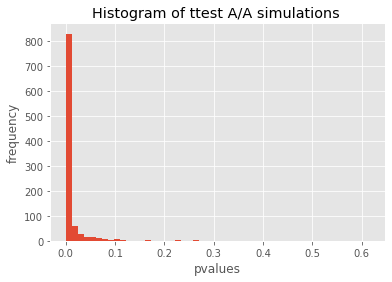

In [192]:
a1 = df.query('experimentVariant == 0').purchase
a2 = df.query('experimentVariant == 1').purchase

aa_pvalues = get_aa_pvalues(a1, a2, simulations, n_s)

# Задача 2
Посчитайте FPR на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000). Вы увидите, что FPR > альфа! Нам нужно наоборот – чтобы было меньше.

In [197]:
# alphas = [0.01, 0.02, 0.03, 0.04, 0.05]
alphas = [0.05]
fpr = get_fpr_by_alpha(aa_pvalues, alphas)
print_conglusion_by_fpr(fpr)

частота ложноположительных случаев 0.934 превышает альфа 0.05


Видно, что результат согласуется с заданием, **FPR** для *0.05* равен *0.934*, что больше *0.05* и указывает на то, что выборки не схожи между собой. Нужно искать причины.

# Задача 3
Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента (подсказка: найдите аномалию в версии приложения).

Посморим на версию выборки в зависимости от версии приложенния **version**

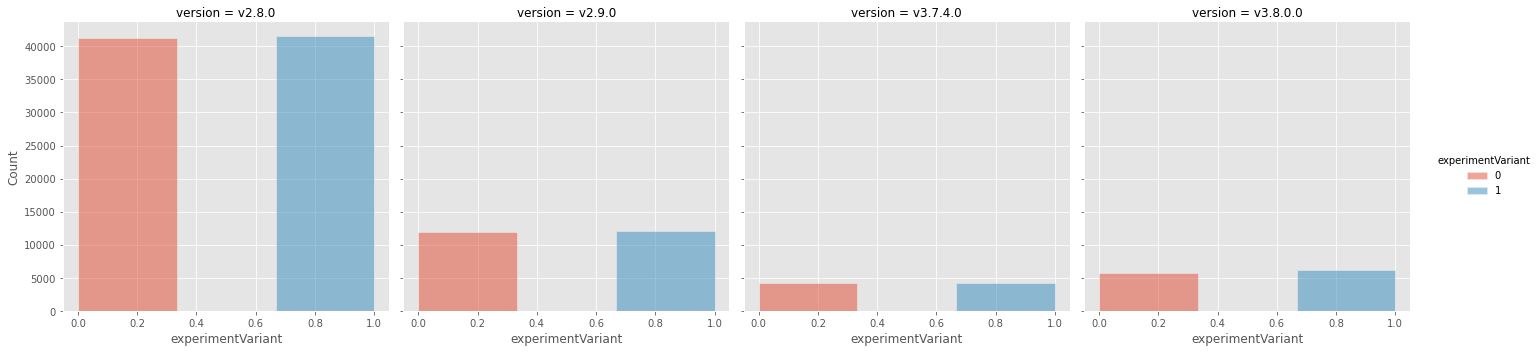

In [164]:
sns.displot(data=df, x='experimentVariant', hue='experimentVariant', col='version', bins=3)

In [165]:
df.groupby(by='version').experimentVariant.value_counts()

version   experimentVariant
v2.8.0    1                    41552
          0                    41283
v2.9.0    1                    12033
          0                    11921
v3.7.4.0  1                     4221
          0                     4204
v3.8.0.0  1                     6110
          0                     5694
Name: experimentVariant, dtype: int64

Посчитаем конверсию в зависимости от версии приложения

In [166]:
df_version_conversion = df.groupby(by='version') \
    .purchase \
    .value_counts(normalize=True) \
    .round(3).mul(100) \
    .to_frame() \
    .rename(columns={'purchase':'conversion'}) \
    .reset_index() \
    .query('purchase == 1')

df_version_conversion

,version,purchase,conversion
1,v2.8.0,1,2.3
3,v2.9.0,1,7.3
5,v3.7.4.0,1,6.1
7,v3.8.0.0,1,6.0


<AxesSubplot:xlabel='version', ylabel='conversion'>

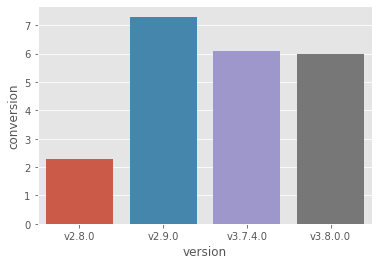

In [167]:
sns.barplot(data=df_version_conversion, x='version', y='conversion')

В версии *v2.8.0* конверсия ниже, чем в других версиях, проверим FPR в разных версиях, вероятно, данные из старой версии портят выборку.

In [183]:
versions = df.version.unique()
versions

array(['v2.8.0', 'v2.9.0', 'v3.7.4.0', 'v3.8.0.0'], dtype=object)

Для каждой версии выполним AA тест и получим **FPR**, но выполним несколько симуляций для каждой версии

In [ ]:
num_tests = 100
alpha_level = [0.05]
df_dict = {'version':[], 'alpha': [], 'fpr':[]}

ВАЖНО! Следующие расчеты выполнялись **~9минут!** Для тестов имеет смысл изменить значение *num_test*.

In [198]:
# разделим выборки
sets = {}
for v in versions:
    sets[v] = []
    sets[v].append(df[df.version == v].query('experimentVariant == 0').purchase)
    sets[v].append(df[df.version == v].query('experimentVariant == 1').purchase)

for i in range(num_tests):
    ver_pvalues = {}
    ver_fpr = {}
    
    for v in versions:
        a1 = sets[v][0]
        a2 = sets[v][1]

        # Запустим AA тест
        ver_pvalues[v] = get_aa_pvalues(a1, a2, simulations, n_s, v, display_hist=False)

        ver_fpr[v] = get_fpr_by_alpha(pvalues=ver_pvalues[v], alpha_levels=alpha_level)

    for v in ver_fpr:
        for a in ver_fpr[v]:
            df_dict['version'].append(v)
            df_dict['alpha'].append(a)
            df_dict['fpr'].append(ver_fpr[v][a])

df_fpr = pd.DataFrame(df_dict)

100%|██████████| 1000/1000 [00:01<00:00, 913.90it/s]


In [243]:
# Выподним оценку FPR для заданных Alpha
df_fpr['is_ok'] = df_fpr['fpr'] <= df_fpr['alpha']

In [225]:
df_fpr_est = df_fpr.groupby(by='version') \
    .is_ok.value_counts(normalize=True) \
    .mul(100).round(2) \
    .to_frame() \
    .rename(columns={'is_ok': 'rate'}) \
    .reset_index() \
    .pivot(index='version', columns='is_ok', values='rate') \
    .fillna(0) \
    .reset_index() \
    .rename_axis(None, axis=1) \
    .rename(columns={True:'ok_rate', False:'not_ok_rate'})

df_fpr_est

,version,not_ok_rate,ok_rate
0,v2.8.0,100.0,0.0
1,v2.9.0,38.0,62.0
2,v3.7.4.0,0.0,100.0
3,v3.8.0.0,83.0,17.0


Итак, видим, что по результатам 100 симуляций AA-тестов для каждой из версий:
* данные из версии *v2.8.0* точно ломают выборку
* данные из версии *v2.9.0* ломают выборку довольно часто (~40%)
* данные из версии *v3.7.4.0* всегда проходят проверку на уровне *0.05*
* данные из версии *v3.8.0.0* ломают выборку довольно часто (~83%)

Оставим только те данные, которые точно не портят выборку

In [231]:
wrong_versions = df_fpr_est[df_fpr_est.not_ok_rate > 0.0].version.values

In [240]:
df_clear = df.query('version not in @wrong_versions')

ver_str = ', '.join(df_clear.version.unique())
ver_str

'v3.7.4.0'

100%|██████████| 1000/1000 [00:00<00:00, 1117.94it/s]


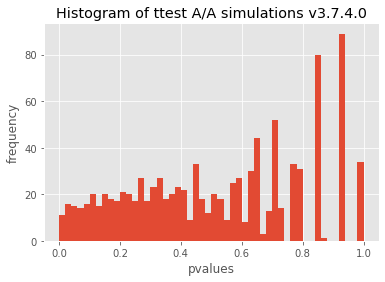

In [241]:
# разделим выборки
a1 = df_clear.query('experimentVariant == 0').purchase
a2 = df_clear.query('experimentVariant == 1').purchase

# запустим AA тест
aa_pvalues_v2 = get_aa_pvalues(a1, a2, simulations, n_s, ver_str)

In [242]:
alphas = [0.01, 0.02, 0.03, 0.04, 0.05]
fpr_v2 = get_fpr_by_alpha(aa_pvalues_v2, alphas)
print_conglusion_by_fpr(fpr_v2)

частота ложноположительных случаев 0.007 НЕ превышает альфа 0.01
частота ложноположительных случаев 0.011 НЕ превышает альфа 0.02
частота ложноположительных случаев 0.016 НЕ превышает альфа 0.03
частота ложноположительных случаев 0.027 НЕ превышает альфа 0.04
частота ложноположительных случаев 0.032 НЕ превышает альфа 0.05


# Задача 4
Напишите выводы, которые можно сделать на основе анализа результатов A/A-теста

Можем сделать следующие выводы:
1. Не стоит смешивать данные из разных версий приложений:
* Например, из имеющихся самая старая версия *v2.8.0* - 100% ломает выборку, это видно из:
    * Графика, построенного для визуализации конверсии по версиям;
    * AA тесты для груп из этой версии показывали высокий уровень ошибки I рода (*FPR*).
* Другие версии могут ломать результаты, но при этом в некоторых случаях AA-тест будет пройден:
    * Если бы не вносил измнения в функции и не перезаускал AA-тест, то не заметил бы этого и вывод был бы совсем другим=).
* Да и это логично, странно запускать тест на данных из разных версих, в разных версиях очень много разных изменений.
2. Одна итерация AA-теста может ввести в заблуждение и показать, что *FPR* низкий и всё ок, нужно более одной итерации.